# Pipeline Completa 6D Pose Estimation con PoseEstimator (Yolo11n + Resnet50)

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD** con split ufficiale train/test
3. **Carica modelli pretrained**
3. **Pipeline completa** YOLO detection → crop → 6D pose estimation

## 1. Import e Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
import pandas as pd
import random


# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from utils.transforms import quaternion_to_rotation_matrix_batch
from dataset.custom_dataset import create_pose_dataloaders
from models.pose_estimator import PoseEstimator
from utils.losses import PoseLoss
from utils.metrics import load_all_models, load_models_info, compute_add_batch

# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


# Configura matplotlib per notebook
%matplotlib inline

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"🔢 Batch size: {Config.POSE_BATCH_SIZE}")

✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224
🔢 Batch size: 64


## 2. Carica dataset LineMOD

In [2]:
# Carica dataset con split ufficiale train/test
print("📦 Caricamento PoseDataset con split ufficiale...\n")

train_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE  # Adaptive: 0 on MPS, optimal on CUDA/CPU
)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento PoseDataset con split ufficiale...

🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 3759 train samples
🚀 Cached 13 gt.yml and 13 info.yml files
🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 21218 test samples
🚀 Cached 13 gt.yml and 13 info.yml files

📊 Pose DataLoaders created:
   Training samples: 3759
   Training batches: 59
   Test samples: 21218
   Test batches: 332
✅ Dataset caricato:
   Train batches: 59 (batch_size=64)
   Test batches: 332
   Train samples: ~3776
   Test samples: ~21248
   Crop margin: 15%
   Output size: 224x224
   Workers: 0 (adaptive per mps)


## 3.Carica Modelli Pre-Trained

Carica il checkpoint salvato e testa su sample del test set.

In [3]:
# ====== CARICAMENTO MODELLI PRE-TRAINED ======
from models.yolo_detector import YOLODetector

# 1. YOLO Fine-tuned per detection
print("=" * 60)
print("📦 CARICAMENTO YOLO DETECTOR")
print("=" * 60)

YOLO_MODEL = 'yolo_train10'
RESNET_MODEL = 'pose_stable_train100'
yolo_weights = Config.CHECKPOINT_DIR / 'yolo' / YOLO_MODEL / 'weights' / 'best.pt'

if yolo_weights.exists():
    print(f"✅ Carico YOLO: {yolo_weights.relative_to(project_root)}\n")
    yolo_detector = YOLODetector(
        model_name=str(yolo_weights),
        num_classes=Config.NUM_CLASSES
    )
    print(f"✅ YOLO caricato con successo!\n")
else:
    print(f"❌ YOLO weights non trovati: {yolo_weights}")
    print(f"   Allena prima YOLO (vedi test_yolo2_finetuning.ipynb)\n")
    yolo_detector = None

# 2. PoseEstimator (ResNet50) per 6D pose
print("=" * 60)
print("📦 CARICAMENTO POSE ESTIMATOR (ResNet50)")
print("=" * 60)

RESNET_MODEL = "pose_stable_train100"
checkpoint_dir = project_root / 'checkpoints' / 'pose' / RESNET_MODEL
checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'

if checkpoint_path.exists():
    print(f"✅ Carico checkpoint: {checkpoint_path.relative_to(project_root)}\n")
    
    # Inizializza modello se non già fatto
    if 'model' not in locals():
        model = PoseEstimator(
            pretrained=True,
            dropout=Config.POSE_DROPOUT,
            freeze_backbone=False  # ✅ Coerente con training
        ).to(Config.DEVICE)
    
    # Carica weights
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"📊 Checkpoint info:")
    print(f"   Epoch: {checkpoint['epoch'] + 1}")
    print(f"   Loss: {checkpoint['loss']:.4f}")
    if 'loss_trans' in checkpoint:
        print(f"   Trans Loss: {checkpoint['loss_trans']:.4f}")
        print(f"   Rot Loss: {checkpoint['loss_rot']:.2f}")
    if 'config' in checkpoint:
        print(f"\n📋 Training config:")
        for key, value in checkpoint['config'].items():
            print(f"      {key}: {value}")
    print(f"\n   Device: {Config.DEVICE}")
    print(f"\n✅ PoseEstimator caricato e in modalità eval!\n")
    
else:
    print(f"❌ Checkpoint non trovato: {checkpoint_path}")
    print(f"   Path cercati:")
    print(f"   1. {project_root / 'checkpoints' / 'pose' / 'pose_stable_train100' / 'weights' / 'best.pt'}")
    print(f"   2. {project_root / 'checkpoints' / 'pose' / 'pose_stable_train70' / 'weights' / 'best.pt'}")
    print(f"   3. {project_root / 'checkpoints' / 'pose' / 'pose_stable_train30' / 'weights' / 'best.pt'}")
    print(f"   4. {project_root / 'checkpoints' / 'pose_best_quick.pth'}")
    print(f"\n   Esegui prima il training (vedi test_yolo3_pose_finetuning.ipynb)")
    print(f"   Oppure cambia RESNET_MODEL con un esperimento esistente\n")
    model = None

# Riepilogo modelli caricati
print("=" * 60)
print("📋 RIEPILOGO MODELLI CARICATI")
print("=" * 60)
print(f"YOLO Detector:    {'✅ Caricato' if yolo_detector is not None else '❌ Non disponibile'}")
print(f"PoseEstimator:    {'✅ Caricato' if model is not None else '❌ Non disponibile'}")
if yolo_detector is not None and model is not None:
    print(f"\n🚀 Tutto pronto per la pipeline completa!")
else:
    print(f"\n⚠️  Alcuni modelli mancano. Verifica i checkpoint.")
print("=" * 60)

📦 CARICAMENTO YOLO DETECTOR
✅ Carico YOLO: checkpoints/yolo/yolo_train10/weights/best.pt

✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train10/weights/best.pt
✅ YOLO caricato con successo!

📦 CARICAMENTO POSE ESTIMATOR (ResNet50)
✅ Carico checkpoint: checkpoints/pose/pose_stable_train100/weights/best.pt



/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
📊 Checkpoint info:
   Epoch: 100
   Loss: 17.1820
   Trans Loss: 4.8458
   Rot Loss: 0.25

📋 Training config:
      phase: Phase 1 - Optimized
      epochs: 100
      warmup_epochs: 5
      lr_backbone: 5e-06
      lr_head: 0.0001
      batch_size: 64
      accumulation_steps: 2
      effective_batch_size: 128
      use_amp: False
      lambda_trans: 1.0
      lambda_rot: 50.0
      dropout: 0.5
      freeze_backbone: False
      scheduler: ReduceLROnPlateau
      device: mps
      image_size: 224
      crop_margin: 0.15

   Device: mps

✅ PoseEstimator caricato e in modalità eval!

📋 RIEPILOGO MODELLI CARICATI
YOLO Detector:    ✅ Caricato
PoseEstimator:    ✅ Caricato

🚀 Tutto pronto per la pipeline completa!


## 4. Pipeline Completa: YOLO Detection + Pose Estimation

Test della pipeline completa end-to-end:
1. YOLO11n fine-tuned rileva oggetti e bbox
2. Crop immagine attorno al bbox
3. PoseEstimator predice 6D pose (quaternion + translation)

🔗 PIPELINE COMPLETA: YOLO Detection + Pose Estimation

📋 Modelli utilizzati:
   YOLO: best.pt
   PoseEstimator: pose_stable_train100
   Device: mps

🎲 Selezione immagine casuale dal dataset...

📷 Immagine selezionata:
   Path: data/09/rgb/0323.png
   Size: 640x480
   Totale immagini disponibili: 15800

🔍 Step 1: YOLO Detection...
   Rilevati 2 oggetti

✂️  Step 2: Crop e Pose Estimation per ogni oggetto...

   [1/2] benchvise (conf=0.63)
         Bbox: [329, 156, 446, 228]
         Quaternion: [-0.209, -0.969, -0.091, -0.094]
         Translation: [0.0, -0.1, 0.3] mm

   [2/2] benchvise (conf=0.35)
         Bbox: [234, 125, 338, 211]
         Quaternion: [-0.035, 0.287, -0.956, -0.052]
         Translation: [-0.0, -0.1, 0.3] mm

📊 Step 3: Visualizzazione risultati...

💡 Corrispondenza:
   • [k] sull'immagine con YOLO = detection k-esima
   • [k] sul crop = stesso oggetto passato al PoseEstimator



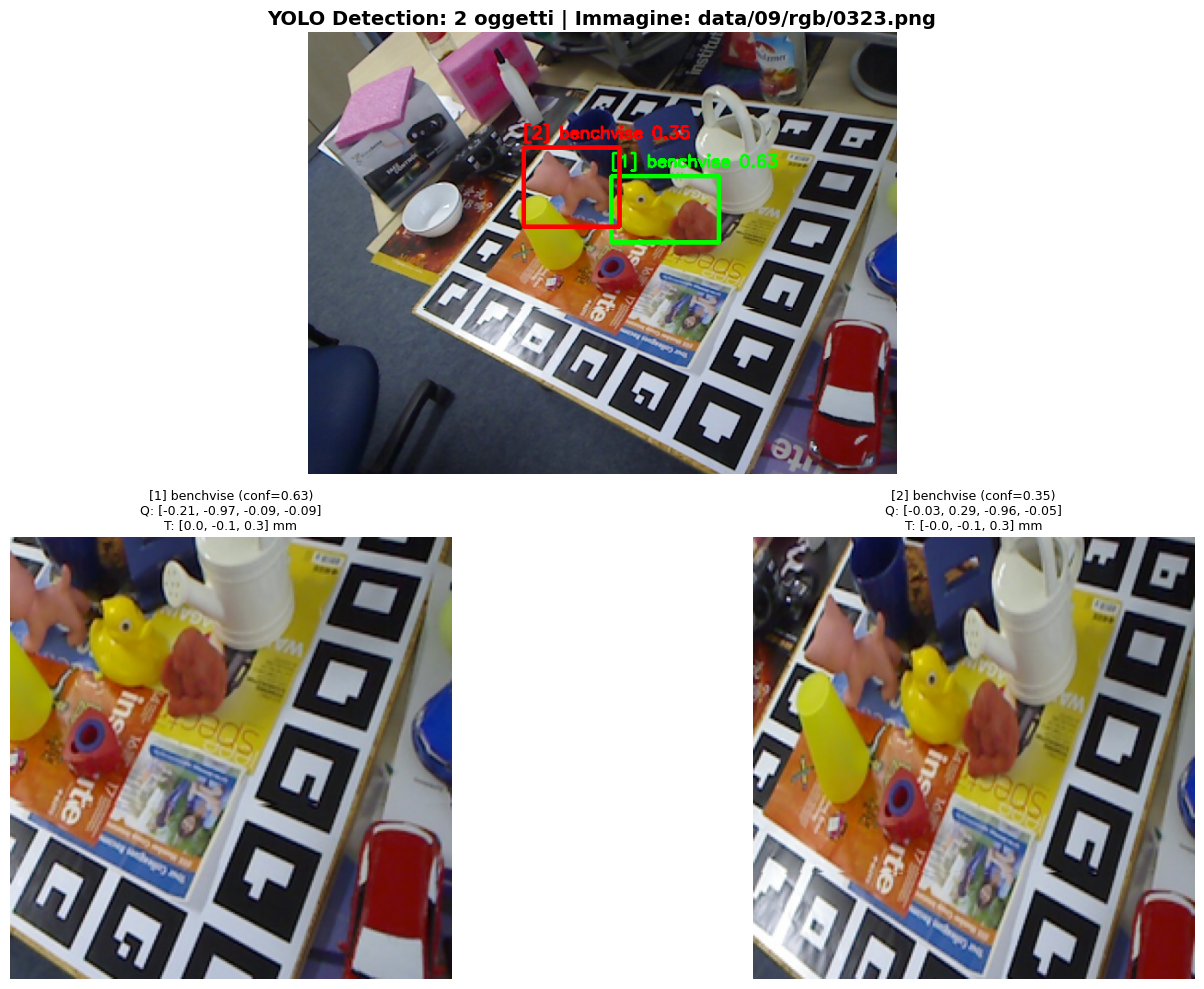

✅ PIPELINE COMPLETATA!
   Oggetti rilevati e pose stimati: 2
   YOLO usato: best.pt
   PoseEstimator usato: pose_stable_train100

💡 Nota: I numeri [1], [2], ... indicano la stessa detection sia:
   • Nel bbox YOLO sull'immagine originale
   • Nel crop mostrato sotto con la posa stimata

🎲 Esegui di nuovo questa cella per testare su un'altra immagine casuale!


In [4]:
# ====== PIPELINE COMPLETA: YOLO → CROP → POSE ESTIMATION ======
from utils.transforms import crop_image_from_bbox, get_pose_transforms
from PIL import Image

# Verifica che i modelli siano caricati
if yolo_detector is None or model is None:
    print("❌ Errore: I modelli non sono caricati!")
    print(f"   YOLO Detector: {'✅' if yolo_detector is not None else '❌'}")
    print(f"   PoseEstimator: {'✅' if model is not None else '❌'}")
    print("\n   Esegui prima la cella precedente per caricare i modelli.")
else:
    print("=" * 60)
    print("🔗 PIPELINE COMPLETA: YOLO Detection + Pose Estimation")
    print("=" * 60)
    
    print(f"\n📋 Modelli utilizzati:")
    print(f"   YOLO: {yolo_weights.name}")
    print(f"   PoseEstimator: {RESNET_MODEL}")
    print(f"   Device: {Config.DEVICE}\n")
    
    # ✅ SELEZIONE IMMAGINE CASUALE: Trova tutte le immagini disponibili
    print("🎲 Selezione immagine casuale dal dataset...\n")
    
    # Lista tutte le cartelle degli oggetti
    data_root = Config.LINEMOD_ROOT / 'data'
    available_images = []
    
    for obj_folder in sorted(data_root.iterdir()):
        if obj_folder.is_dir() and obj_folder.name.isdigit():
            rgb_folder = obj_folder / 'rgb'
            if rgb_folder.exists():
                # Trova tutte le immagini PNG
                images_in_folder = list(rgb_folder.glob('*.png'))
                available_images.extend(images_in_folder)
    
    if not available_images:
        print("❌ Nessuna immagine trovata nel dataset")
    else:
        # Seleziona un'immagine casuale
        test_img_path = random.choice(available_images)
        test_image = np.array(Image.open(test_img_path).convert('RGB'))
        
        # Estrai informazioni dal path
        obj_id = test_img_path.parent.parent.name
        img_name = test_img_path.name
        
        print(f"📷 Immagine selezionata:")
        print(f"   Path: data/{obj_id}/rgb/{img_name}")
        print(f"   Size: {test_image.shape[1]}x{test_image.shape[0]}")
        print(f"   Totale immagini disponibili: {len(available_images)}\n")
        
        # Step 1: YOLO detection
        print("🔍 Step 1: YOLO Detection...")
        detections = yolo_detector.detect_objects(test_image, conf_threshold=0.3)
        print(f"   Rilevati {len(detections)} oggetti\n")
        
        if len(detections) == 0:
            print("❌ Nessun oggetto rilevato. Prova con un'altra immagine o lower confidence threshold.")
            print("   💡 Esegui di nuovo la cella per selezionare un'altra immagine casuale")
        else:
            # Step 2: Crop e Pose Estimation per ogni detection
            print("✂️  Step 2: Crop e Pose Estimation per ogni oggetto...\n")
            
            pose_transforms = get_pose_transforms(train=False)
            results = []
            
            for idx, det in enumerate(detections):
                bbox = det['bbox']  # [x1, y1, x2, y2]
                obj_name = det['class_name']
                conf = det['confidence']
                
                print(f"   [{idx+1}/{len(detections)}] {obj_name} (conf={conf:.2f})")
                print(f"         Bbox: [{int(bbox[0])}, {int(bbox[1])}, {int(bbox[2])}, {int(bbox[3])}]")
                
                # Crop con margin (ritorna già PIL Image)
                cropped = crop_image_from_bbox(
                    test_image,
                    bbox,
                    margin=Config.POSE_CROP_MARGIN,
                    output_size=(Config.POSE_IMAGE_SIZE, Config.POSE_IMAGE_SIZE)
                )
                
                # Preprocessing (cropped è già PIL Image, no fromarray needed)
                cropped_tensor = pose_transforms(cropped)
                cropped_tensor = cropped_tensor.unsqueeze(0).to(Config.DEVICE)
                
                # Pose prediction con il modello caricato
                with torch.no_grad():
                    pred_quat, pred_trans = model(cropped_tensor)
                
                pred_quat = pred_quat[0].cpu().numpy()
                pred_trans = pred_trans[0].cpu().numpy()
                
                results.append({
                    'bbox': bbox,
                    'class_name': obj_name,
                    'confidence': conf,
                    'quaternion': pred_quat,
                    'translation': pred_trans,
                    'cropped': np.array(cropped)  # crop "pulito", solo per visualizzazione
                })
                
                print(f"         Quaternion: [{pred_quat[0]:.3f}, {pred_quat[1]:.3f}, {pred_quat[2]:.3f}, {pred_quat[3]:.3f}]")
                print(f"         Translation: [{pred_trans[0]:.1f}, {pred_trans[1]:.1f}, {pred_trans[2]:.1f}] mm\n")
            
            # Step 3: Visualizzazione
            print(f"📊 Step 3: Visualizzazione risultati...\n")
            print("💡 Corrispondenza:")
            print("   • [k] sull'immagine con YOLO = detection k-esima")
            print("   • [k] sul crop = stesso oggetto passato al PoseEstimator\n")
            
            n_detections = len(results)
            n_cols = min(3, n_detections)
            n_rows = (n_detections + n_cols - 1) // n_cols
            
            # Create figure with GridSpec for custom layout
            fig = plt.figure(figsize=(15, 5 * (n_rows + 1)))
            
            # ✅ Draw bounding boxes sull'immagine originale
            img_with_bbox = test_image.copy()
            try:
                import cv2
                colors_bgr = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
                for idx, res in enumerate(results):
                    x1, y1, x2, y2 = res['bbox']
                    color = colors_bgr[idx % len(colors_bgr)]
                    cv2.rectangle(img_with_bbox, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)
                    # Label con numero per tracciare corrispondenza
                    label = f"[{idx+1}] {res['class_name']} {res['confidence']:.2f}"
                    cv2.putText(
                        img_with_bbox,
                        label,
                        (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        color,
                        2
                    )
            except ImportError:
                print("⚠️  OpenCV non installato. Visualizzazione senza bounding boxes...")
                print("   Per installarla: pip install opencv-python\n")
            
            # Immagine originale con bbox (riga in alto, tutte le colonne)
            ax_orig = plt.subplot2grid((n_rows + 1, n_cols), (0, 0), colspan=n_cols)
            ax_orig.imshow(img_with_bbox)
            ax_orig.set_title(
                f"YOLO Detection: {n_detections} oggetti | Immagine: data/{obj_id}/rgb/{img_name}", 
                fontsize=14, fontweight='bold'
            )
            ax_orig.axis('off')
            
            # Crops con pose (righe sotto) - Numerati per corrispondenza
            for idx, res in enumerate(results):
                row = (idx // n_cols) + 1
                col = idx % n_cols
                ax = plt.subplot2grid((n_rows + 1, n_cols), (row, col))
                ax.imshow(res['cropped'])
                title = (
                    f"[{idx+1}] {res['class_name']} (conf={res['confidence']:.2f})\n"
                    f"Q: [{res['quaternion'][0]:.2f}, {res['quaternion'][1]:.2f}, "
                    f"{res['quaternion'][2]:.2f}, {res['quaternion'][3]:.2f}]\n"
                    f"T: [{res['translation'][0]:.1f}, {res['translation'][1]:.1f}, {res['translation'][2]:.1f}] mm"
                )
                ax.set_title(title, fontsize=9)
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"=" * 60)
            print(f"✅ PIPELINE COMPLETATA!")
            print(f"=" * 60)
            print(f"   Oggetti rilevati e pose stimati: {n_detections}")
            print(f"   YOLO usato: {yolo_weights.name}")
            print(f"   PoseEstimator usato: {RESNET_MODEL}")
            print(f"\n💡 Nota: I numeri [1], [2], ... indicano la stessa detection sia:")
            print(f"   • Nel bbox YOLO sull'immagine originale")
            print(f"   • Nel crop mostrato sotto con la posa stimata")
            print(f"\n🎲 Esegui di nuovo questa cella per testare su un'altra immagine casuale!")
            print(f"=" * 60)